In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import transform

In [3]:
photo_size=224

In [10]:
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale= 1/255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=32,
        classes=['non_autistic','autistic']
    )
    return generator

In [11]:
train_data=prepare_dataset('./autistic-children-facial-data-set/train/')
validation_data = prepare_dataset('./autistic-children-facial-data-set/valid/')
test_data=prepare_dataset('./autistic-children-facial-data-set/test/')

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [12]:
validation_data.class_indices

{'non_autistic': 0, 'autistic': 1}

In [13]:
# example of tending the vgg16 model
def create_vgg19_model():
    from keras.applications.vgg19 import VGG19
    from keras.models import Model
    from keras.layers import Dense
    from keras.layers import Flatten
    # load model without classifier layers
    model = VGG19(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [1,2,3,15,16,17,18]:
            model.layers[layer_idx].trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(256, activation='relu')(flat1)
    output = Dense(95, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [14]:
vgg19_model=create_vgg19_model()
vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg19hist=vgg19_model.fit(
    train_data,
    epochs=100,
    validation_data=validation_data 
    
)
vgg19_model.save("vgg19_model50.h5")

Epoch 1/100
80/80 [==============================] - 53s 475ms/step - loss: 1.0197 - accuracy: 0.5398 - val_loss: 0.6989 - val_accuracy: 0.5700
Epoch 2/100
80/80 [==============================] - 34s 423ms/step - loss: 0.6462 - accuracy: 0.6234 - val_loss: 0.6468 - val_accuracy: 0.6300
Epoch 3/100
80/80 [==============================] - 34s 421ms/step - loss: 0.6181 - accuracy: 0.6487 - val_loss: 0.6893 - val_accuracy: 0.5500
Epoch 4/100
80/80 [==============================] - 34s 422ms/step - loss: 0.5622 - accuracy: 0.7086 - val_loss: 0.9632 - val_accuracy: 0.5700
Epoch 5/100
80/80 [==============================] - 35s 429ms/step - loss: 0.5615 - accuracy: 0.7141 - val_loss: 0.5405 - val_accuracy: 0.7200
Epoch 6/100
80/80 [==============================] - 34s 420ms/step - loss: 0.5117 - accuracy: 0.7512 - val_loss: 0.4527 - val_accuracy: 0.7700
Epoch 7/100
80/80 [==============================] - 34s 423ms/step - loss: 0.5056 - accuracy: 0.7532 - val_loss: 0.5297 - val_accuracy:

80/80 [==============================] - 33s 411ms/step - loss: 0.2716 - accuracy: 0.8912 - val_loss: 0.4401 - val_accuracy: 0.7800
Epoch 58/100
80/80 [==============================] - 35s 429ms/step - loss: 0.2776 - accuracy: 0.8841 - val_loss: 0.4809 - val_accuracy: 0.7700
Epoch 59/100
80/80 [==============================] - 34s 428ms/step - loss: 0.2422 - accuracy: 0.9030 - val_loss: 0.5721 - val_accuracy: 0.7800
Epoch 60/100
80/80 [==============================] - 35s 432ms/step - loss: 0.2379 - accuracy: 0.8983 - val_loss: 0.4388 - val_accuracy: 0.8300
Epoch 61/100
80/80 [==============================] - 36s 442ms/step - loss: 0.2648 - accuracy: 0.8927 - val_loss: 0.4344 - val_accuracy: 0.7900
Epoch 62/100
80/80 [==============================] - 34s 426ms/step - loss: 0.2584 - accuracy: 0.8916 - val_loss: 0.5504 - val_accuracy: 0.7600
Epoch 63/100
80/80 [==============================] - 34s 419ms/step - loss: 0.2402 - accuracy: 0.9002 - val_loss: 0.4086 - val_accuracy: 0.820

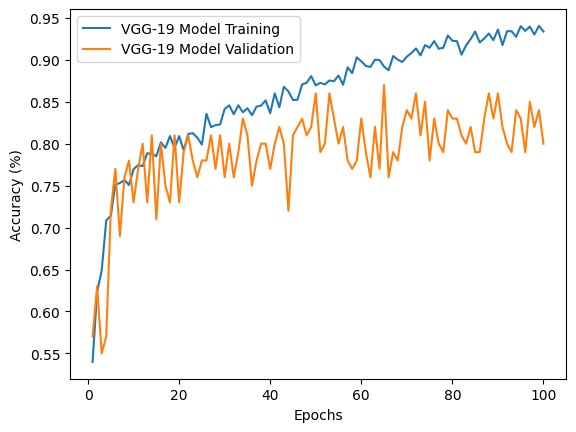

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(x, vgg19hist.history['accuracy'], label = "VGG-19 Model Training", linestyle="-")
plt.plot(x, vgg19hist.history['val_accuracy'], label = "VGG-19 Model Validation", linestyle="-")
plt.legend()
plt.show()

In [17]:
vgg19_model.evaluate(test_data)

10/10 [==============================] - 6s 564ms/step - loss: 0.4111 - accuracy: 0.8467


[0.4110613465309143, 0.846666693687439]

In [18]:
vgg19_model.evaluate(train_data)

80/80 [==============================] - 33s 407ms/step - loss: 0.1466 - accuracy: 0.9432


[0.14660073816776276, 0.9432176947593689]

In [19]:
vgg19_model.evaluate(validation_data)

4/4 [==============================] - 1s 272ms/step - loss: 0.5444 - accuracy: 0.7700


[0.5444093346595764, 0.7699999809265137]

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = vgg19_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

10/10 [==============================] - 4s 379ms/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       150
           1       0.53      0.53      0.53       150

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.53       300
weighted avg       0.53      0.53      0.53       300



<Axes: >

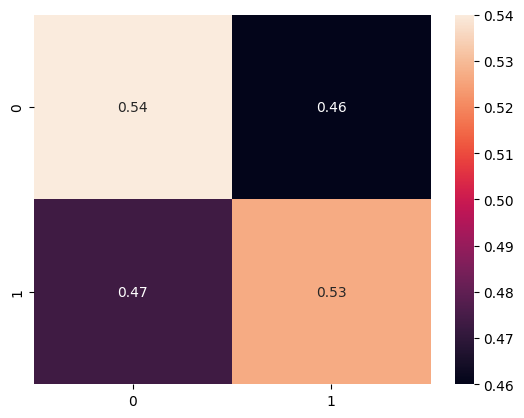

In [23]:
import seaborn as sns
cm = confusion_matrix(test_data.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)